## ModelOptions vs SolverOptions


The distinction between **`ModelOptions`** and **`SolverOptions`** is essential when working with `optiwindnet`.
This notebook presents a clear and structured explanation of their roles and differences:

- **`ModelOptions`** define *how the optimization problem is formulated*, including structural assumptions and model features such as topology type, feeder constraints, and balancing requirements.
- **`SolverOptions`** configure *how the underlying solver behaves during execution*, controlling aspects like time limits, optimality gaps, and so on.

Understanding this separation helps ensure that models are both correctly formulated and efficiently solved.

---

### 🔧 What is `ModelOptions`?

`ModelOptions` is a configuration object or dictionary that **controls how the mathematical model is built and behaves**, regardless of the solver used. These options are typically **high-level**, problem-specific settings that:

* Affect the **structure** of the model (e.g., topology type)
* Enable or disable **features** (e.g., balancing constraints)
* Influence **heuristic/metaheuristic behavior** if used

#### ✅ Examples of `ModelOptions`:

| Parameter      | Description                                                                 |
| -------------- | --------------------------------------------------------------------------- |
| `topology`     | Controls whether the solution allows "radial" or "branched" subtrees        |
| `feeder_route` | Determines if feeder paths must be "straight" or may be "segmented"         |
| `feeder_limit` | Specifies limits on the number of feeders used in the solution              |
| `balanced`     | Whether subtree loads must be balanced                                      |
| `max_feeders`  | Required when `feeder_limit="specified"` to indicate the max number allowed |

These options **change the formulation** of the problem before it is handed to the solver.

### ModelOptions Capability Summary

| Method           | Topology                                                              | Feeder Route                                                      | Feeder Limit                                                    |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------|------------------------------------------------------------------|
| **Heuristic**      | May produce *branched* or *radial* topologies; not user-controllable | May yield *straight* or *segmented* routes; no control available   | Not controllable                                                 |
| **Metaheuristic**  | Always produces *radial* topology                                     | May yield *straight* or *segmented* routes; not user-controllable | Controllable via `feeder_limit` parameter in `ModelOptions`              |
| **MILP**           | Fully controllable via `topology` parameter in `ModelOptions`         | Fully controllable via `feeder_route` parameter in `ModelOptions`                   | Fully controllable via `feeder_limit` parameter in `ModelOptions`   |


In [1]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MetaHeuristic, MILP, ModelOptions, load_repository

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

See ModelOptions help

In [3]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



## Optimize an examplary location

### Initialize Moray East

>In this example, the `load_repository()` functionality is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [4]:
locations = load_repository()
wfn = WindFarmNetwork(L=locations.seagreen, cables=5)

<Axes: >

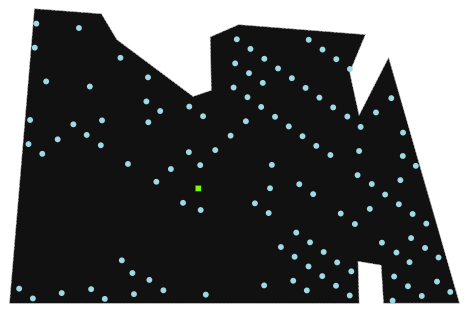

In [5]:
wfn.plot_location()

#### Optimize with Heurisitc-Esau_Williams with following ModelOptions:

```python
- topology='branched'
- feeder_limit='unlimited'
- feeder_route='segmented'
````

In [6]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_EW = Heuristic(solver='Esau_Williams', model_options=model_options)
res_EW= wfn.optimize(router=router_EW)


### ✅ Heuristic Solvers

**In the current version of `OptiWindNet`, `ModelOptions` are not supported by `Heuristic-Esau_Williams` and `Heuristic-CPEW`.**

* These solvers **do not accept `ModelOptions` as an argument**, and their behavior is unaffected by its settings.
* `CPEW` **always produces straight feeder routes** by design.
* Neither solver enforces **radial topologies** or **feeder limits**, even if such preferences are specified.

Optimize with `Heuristic-Esau_Williams`

<Axes: >

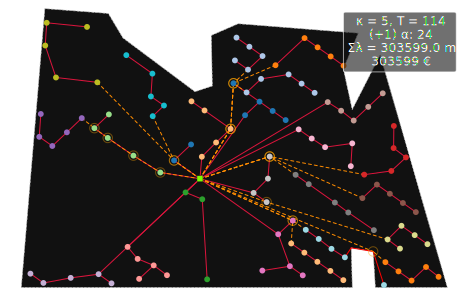

In [7]:
#
router_EW = Heuristic(solver='Esau_Williams', model_options=model_options)
res_EW= wfn.optimize(router=router_EW)
wfn.plot()

Optimize with `Heuristic-CPEW`

Notice that the topology is radial.

<Axes: >

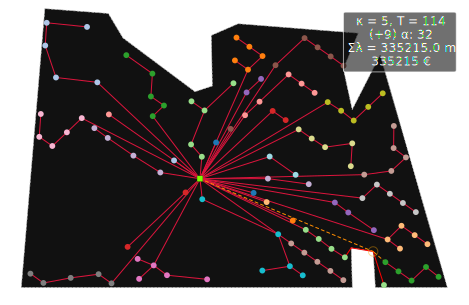

In [8]:
router_cpew = Heuristic(solver='CPEW', model_options=model_options)
res_cpew= wfn.optimize(router=router_cpew)
wfn.plot()

### Metaheuristic Solver (`HGS`)

**`Metaheuristic-HGS` does not support `ModelOptions` in its current format.**

* Instead, it accepts key configuration options — such as `feeder_limit` and `balanced` — as **individual arguments** passed directly to the solver.

  * **Default values**:

    * `balanced = False`
    * `feeder_limit` is flexible and generally favors minimizing total cable length:

      * For locations with **one substation**, `feeder_limit` can be adjusted.
      * For locations with **multiple substations**, the `feeder_limit` argument is **ignored**, and the number of feeders is fixed to the **minimum required**.
* Other `ModelOptions` parameters — such as `topology` and `feeder_route` — are **not currently supported**.

<Axes: >

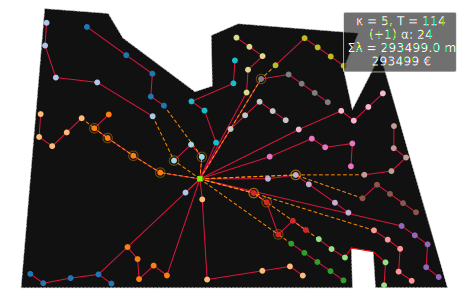

In [9]:
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=2)
res_hgs= wfn.optimize(router=router_hgs)
wfn.plot()

Vehicle number (20) too low for feasibilty with capacity (5). Setting to 23.


<Axes: >

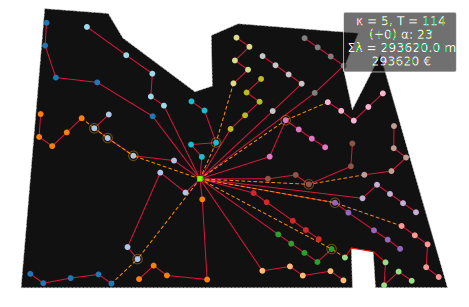

In [10]:
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=2, feeder_limit=20)
res_hgs= wfn.optimize(router=router_hgs)
wfn.plot()

<Axes: >

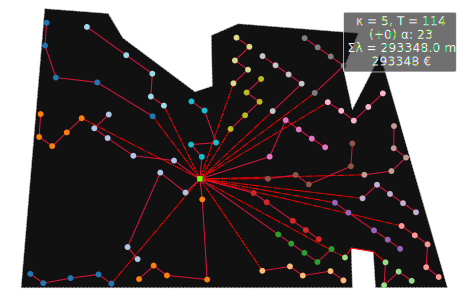

In [11]:
wfn.plot_selected_links()

<Axes: >

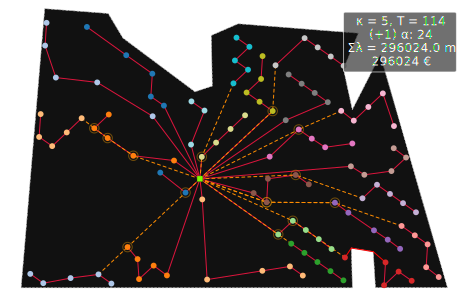

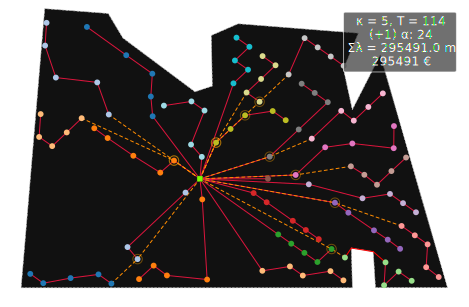

In [12]:
# create the logic of warmstarting for MILP

model_options = ModelOptions(
                        topology='radial',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=0.5, model_options=model_options)
res_EW= wfn.optimize(router=router_hgs)
wfn.plot()


model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='minimum',
                        feeder_route='straight',
)
router_hgs = MetaHeuristic(solver='HGS', time_limit=0.5, model_options=model_options)
res_EW= wfn.optimize(router=router_hgs)
wfn.plot()

#### Optimize again using `Heuristic-CPEW`

For `Heuristic-CPEW`, we run optimization with two sets of ModelOptions:


| Model Option   | Set 1       | Set 2       |
| -------------- | ----------- | ----------- |
| **topology**     | `branched`  | `radial`    |
| **feeder_limit** | `unlimited` | `minimum`   |
| **feeder_route** | `straight` | `segmented` |

With `Heuristic-CPEW`, we observe the following:

- **`topology='radial'`** has no effect on the solution.
  Although the resulting topology might be radial, this is not guaranteed. The `topology` setting in `ModelOptions` does not influence how `CPEW` constructs the solution.

- **`feeder_limit='minimum'`** has no effect on the solution.
  While the number of feeders may be low in the final layout, `CPEW` does not optimize for or enforce any constraint on the number of feeders. The `feeder_limit` parameter is ignored.

- **`feeder_route='segmented'`** does not control the behavior, but the result always complies.
  `CPEW` inherently produces layouts where all feeder routes are straight, regardless of the `feeder_route` setting in `ModelOptions`.

In summary, `Heuristic-CPEW` enforces straight feeder routes by design, but it does not take `ModelOptions` into account for topology or feeder limit. Any alignment with these options is incidental.

### Warmstarter Compatibility with ModelOptions

| **Model Option** | **Value**     | **Warmstarter**         |
|------------------|---------------|-------------------------|
| **Feeder limit** | Unlimited     | ✅ all works           |
|                  | Minimum       | only Metaheuristic-HGS  |
| **Feeder route** | Straight      | only Heuristic-CPEW     |
|                  | Segmented     | ✅ all works           |
| **Topology**     | Branched      | ✅ all works            |
|                  | Radial        | only Metaheuristic-HGS  |


In [14]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='minimum',
                        feeder_route='straight',
                    )
#wfn.optimize(router=router_EW)
#wfn.optimize(router=router_cpew)
router_milp1 = MILP(solver_name='cplex', time_limit=30, mip_gap=0.01, model_options=model_options,  verbose=True)
res = wfn.optimize(router=router_milp1)


    - number of feeders (24) exceeds feeder limit (23)
    - detours present but feeder_route is set to "straight"



Version identifier: 22.1.2.0 | 2024-11-25 | 0edbb82fd
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                -1
CPXPARAM_Emphasis_MIP                            4
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_MIPGap                   0.01
Retaining values of one MIP start for possible repair.
Tried aggregator 1 time.
MIP Presolve eliminated 1124 rows and 0 columns.
MIP Presolve modified 1459 coefficients.
Reduced MIP has 4714 rows, 2396 columns, and 19537 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (20.26 ticks)
Probing time = 0.03 sec. (3.05 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4714 rows, 2396 columns, and 19537 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.56 ticks)
Probing time = 0.02 sec. (2.80 ticks)
Clique table members: 2087.
MIP emphasis: hid

<Axes: >

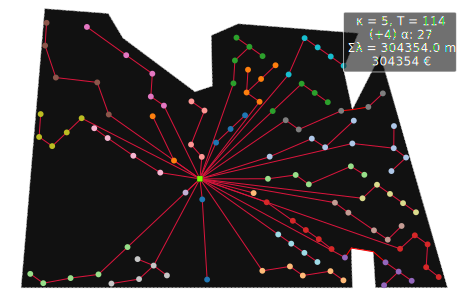

In [ ]:
wfn.plot()

In [ ]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



In [ ]:
model_options = ModelOptions(
                        topology='radial',
                        feeder_limit='unlimited',
                        feeder_route='straight',
                    )

router_milp2 = MILP(solver_name='cplex', time_limit=15, mip_gap=0.005, model_options=model_options,  verbose=True)
res = wfn.optimize(router=router_milp2)

D 0

    - branched structure not allowed under "radial" topology



Version identifier: 22.1.2.0 | 2024-11-25 | 0edbb82fd
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                -1
CPXPARAM_Emphasis_MIP                            4
CPXPARAM_TimeLimit                               15
CPXPARAM_MIP_Tolerances_MIPGap                   0.0050000000000000001
Retaining values of one MIP start for possible repair.
Found incumbent of value 1033133.765873 after 0.02 sec. (2.70 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1237 rows and 0 columns.
MIP Presolve modified 2543 coefficients.
Reduced MIP has 4713 rows, 2396 columns, and 18481 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (20.97 ticks)
Probing time = 0.01 sec. (2.92 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4713 rows, 2396 columns, and 18481 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.77 tick

In [ ]:
from optiwindnet.utils import F
import math

# Access key components
model_options = wfn.router.model_options
G = wfn.S
R = G.graph['R']
T = G.graph['T']
capacity = G.graph['capacity']
D = wfn.G.graph['D']

# Roots and labels
roots = range(1, R + 1)
RootL = {-r: G.nodes[-r].get('label', F[-r]) for r in roots}

# Checks
reasons = []

# Feeder constraint
feeder_counts = [G.degree[r] for r in RootL]
feeder_limit = math.ceil(T / capacity)
if feeder_counts[0] > feeder_limit:
    reasons.append("number of feeders exceeds feeder limit")

# Detour constraint
if D > 0 and model_options.get('feeder_route') == 'straight':
    reasons.append('detours present but feeder_route is set to "straight"')

# Topology constraint
branched_nodes = [n for n in G.nodes if n > 0 and G.degree[n] > 2]
if branched_nodes and model_options.get('topology') == 'radial':
    reasons.append('branched structure not allowed under "radial" topology')

# Output final message
if reasons:
    print("No warmstarting (even though a solution is available) due to the following reason(s):")
    for reason in reasons:
        print(f"- {reason}")
else:
    print("Warmstarting is possible.")


KeyError: 'D'

In [ ]:
wfn.sf

In [ ]:
res_cpew= wfn.optimize(router=router_cpew)
res = wfn.optimize(router=router_milp2)
wfn.length()


In [ ]:
wfn.length()

In [ ]:
router_milp2.optiwindnet_default_options

In [ ]:
wfn.plot()

In [ ]:
solver_options=dict(
    num_workers = 8,
)

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

router_milp = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)

res = wfn.optimize(router=router_milp)

### 🧮 What is `SolverOptions`?

`SolverOptions` refers to **solver-specific configuration parameters** that affect **how the solver works internally** (once the model is already built).

These settings are typically passed directly to a solver like CPLEX, Gurobi, CBC, etc., and influence:

* **Search strategy**
* **Runtime limits**
* **Optimality tolerances**
* **Logging and precision settings**

#### ✅ Common `SolverOptions` for MILP:

| Parameter      | Description                                           |
| -------------- | ----------------------------------------------------- |
| `time_limit`   | Maximum allowed solve time (in seconds)               |
| `gap`          | Optimality tolerance (e.g., 0.01 for 1% gap)          |
| `mip_emphasis` | Prioritize bound quality, feasibility, or integrality |
| `threads`      | Number of threads to use                              |

You can see the solveroptions modified by optiwindnet after creating an instance of the MILP solver via:
```python
router.optiwindnet_default_options
```

>If desired, set the logging level to `INFO` **before running `.optimize()` with the MILP router** to display detailed messages about the solver configuration and warm-start behavior:
>```python
>import logging
>logging.basicConfig(level=logging.INFO)
>```

In [ ]:
router_ortools = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01,  verbose=True)
router_ortools.optiwindnet_default_options

In [ ]:
router_cplex = MILP(solver_name='cplex', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cplex.optiwindnet_default_options

In [ ]:
router_cbc = MILP(solver_name='cbc', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

In [ ]:
router_cbc = MILP(solver_name='gurobi', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

In [ ]:
router_cbc = MILP(solver_name='highs', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

In [ ]:
router_cbc = MILP(solver_name='scip', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

For a complete list of available options for each MILP solver, please refer to the corresponding solver's official documentation or user manual.

---

### 🆚 Key Differences between ModelOptions and SolverOptions

| Feature       | `ModelOptions`                                 | `SolverOptions`                           |
| ------------- | ---------------------------------------------- | ----------------------------------------- |
| Scope         | Problem formulation level                      | Solver execution level                    |
| Affects       | Model structure and constraints                | Search process and performance            |
| Applicable to | All methods (heuristics, metaheuristics, MILP) | Only solver-based methods (e.g., MILP)    |
| Examples      | `topology`, `feeder_limit`, `balanced`         | `time_limit`, `gap`, `threads`            |
| Impact        | Determines **what** is solved                  | Determines **how** it's solved            |
| Defined by    | The modeling framework                         | The specific solver (e.g., CPLEX, Gurobi) |

---

### 🎯 Summary

* **Use `ModelOptions`** to specify **what kind of solution** you want (structure, constraints, flexibility).
* **Use `SolverOptions`** to control **how long and how hard** the solver should try to find that solution.